In [14]:
%pwd

'/itf-fi-ml/home/arunps/Projects/speaker-type-classifier'

In [2]:
import os
os.chdir("../")

In [3]:
%pwd

'/itf-fi-ml/home/arunps/Projects/speaker-type-classifier'

In [23]:
import os
from pathlib import Path
import time
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)
from xgboost import XGBClassifier


In [16]:
RUN_ID = "run_20260203_161558"
FEATURE_ROOT = Path("/scratch/users/arunps/speaker-type-classifier/artifacts_feature_store/v1")

EGEMAPS_DIR = FEATURE_ROOT / "egemaps" / RUN_ID
W2V_DIR     = FEATURE_ROOT / "wav2vec2" / RUN_ID

ID2LABEL = {0: "adult_male", 1: "adult_female", 2: "child", 3: "background"}
LABELS = [ID2LABEL[i] for i in sorted(ID2LABEL)]

def load_pack(feature_dir: Path):
    Xtr = np.load(feature_dir / "train_X.npy")
    ytr = np.load(feature_dir / "train_y.npy")
    Xva = np.load(feature_dir / "val_X.npy")
    yva = np.load(feature_dir / "val_y.npy")
    return Xtr, ytr, Xva, yva

Xtr_e, ytr, Xva_e, yva = load_pack(EGEMAPS_DIR)
Xtr_w, ytr2, Xva_w, yva2 = load_pack(W2V_DIR)

assert np.array_equal(ytr, ytr2)
assert np.array_equal(yva, yva2)

print("eGeMAPS:", Xtr_e.shape, Xva_e.shape)
print("wav2vec2:", Xtr_w.shape, Xva_w.shape)


eGeMAPS: (54068, 88) (13517, 88)
wav2vec2: (54068, 768) (13517, 768)


In [17]:
def check_gpu():
    try:
        import torch
        print("torch.cuda.is_available():", torch.cuda.is_available())
        if torch.cuda.is_available():
            print("GPU:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("Torch check skipped:", e)

check_gpu()

# show CUDA_VISIBLE_DEVICES
print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))


torch.cuda.is_available(): True
GPU: NVIDIA GeForce RTX 2080 Ti
CUDA_VISIBLE_DEVICES: None


In [18]:
def compute_metrics(y_true, y_pred, labels, label_names):
    acc = accuracy_score(y_true, y_pred)

    # per-class precision/recall/f1 and supports
    p, r, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    # UAR = macro recall
    uar = float(np.mean(r))

    # Macro F1
    macro_f1 = float(np.mean(f1))

    df = pd.DataFrame({
        "label_id": labels,
        "label": label_names,
        "support": sup,
        "precision": p,
        "recall": r,
        "f1": f1,
    })

    return {
        "accuracy": float(acc),
        "uar_macro_recall": float(uar),
        "macro_f1": float(macro_f1),
        "per_class": df,
    }


def plot_confusion_matrices(y_true, y_pred, labels, label_names, title_prefix=""):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Row-normalized => recall view (how each true class is predicted)
    row_sum = cm.sum(axis=1, keepdims=True)
    cm_recall = np.divide(cm, row_sum, out=np.zeros_like(cm, dtype=float), where=row_sum != 0)

    # Col-normalized => precision view (what predicted class contains)
    col_sum = cm.sum(axis=0, keepdims=True)
    cm_precision = np.divide(cm, col_sum, out=np.zeros_like(cm, dtype=float), where=col_sum != 0)

    def _plot(mat, title, fmt="{:.2f}"):
        plt.figure()
        plt.imshow(mat, aspect="auto")
        plt.title(title)
        plt.xticks(range(len(label_names)), label_names, rotation=30, ha="right")
        plt.yticks(range(len(label_names)), label_names)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        # annotate
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                plt.text(j, i, fmt.format(mat[i, j]), ha="center", va="center", fontsize=8)
        plt.tight_layout()
        plt.show()

    # Raw counts
    _plot(cm.astype(float), f"{title_prefix} Confusion Matrix (counts)", fmt="{:.0f}")

    # Recall-normalized (rows sum to 1)
    _plot(cm_recall, f"{title_prefix} Confusion Matrix (row-normalized = recall)", fmt="{:.2f}")

    # Precision-normalized (cols sum to 1)
    _plot(cm_precision, f"{title_prefix} Confusion Matrix (col-normalized = precision)", fmt="{:.2f}")

    return cm, cm_recall, cm_precision


In [19]:
import time
import numpy as np
from xgboost import XGBClassifier

def train_xgb_gpu_fallback(Xtr, ytr, Xva, yva, title, seed=42):
    base_params = dict(
        objective="multi:softprob",
        num_class=4,
        n_estimators=1200,
        learning_rate=0.05,
        max_depth=10,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        eval_metric="mlogloss",
        random_state=seed,
        tree_method="hist",   
    )

    # Try GPU first and fall back to CPU if it fails
    try:
        params = dict(base_params)
        params.update(device="cuda")
        clf = XGBClassifier(**params)
        t0 = time.time()
        clf.fit(Xtr, ytr, verbose=False)
        train_time = time.time() - t0
        mode = "cuda"
    except Exception as e:
        print(f"GPU training failed for {title}. Falling back to CPU.\nError: {e}\n")
        params = dict(base_params)
        params.update(device="cpu", n_jobs=16)
        clf = XGBClassifier(**params)
        t0 = time.time()
        clf.fit(Xtr, ytr, verbose=False)
        train_time = time.time() - t0
        mode = "cpu"

    y_pred = clf.predict(Xva)

    labels = list(sorted(ID2LABEL.keys()))
    metrics = compute_metrics(
        yva, y_pred,
        labels=labels,
        label_names=[ID2LABEL[i] for i in labels]
    )

    print("\n==============================")
    print(f"{title} ({mode})")
    print("Train time (sec):", round(train_time, 2))
    print("Accuracy:", round(metrics["accuracy"], 6))
    print("UAR (macro recall):", round(metrics["uar_macro_recall"], 6))
    print("Macro F1:", round(metrics["macro_f1"], 6))

    display(metrics["per_class"].sort_values("support", ascending=False))

    plot_confusion_matrices(
        yva, y_pred,
        labels=labels,
        label_names=[ID2LABEL[i] for i in labels],
        title_prefix=f"{title} ({mode})"
    )

    return clf, metrics



XGBoost — eGeMAPS (cuda)
Train time (sec): 26.21
Accuracy: 0.944366
UAR (macro recall): 0.936732
Macro F1: 0.936458


,label_id,label,support,precision,recall,f1
0,0,adult_male,4000,0.979016,0.979750,0.979383
1,1,adult_female,4000,0.985120,0.976500,0.980791
3,3,background,2840,0.887574,0.897887,0.892701
2,2,child,2677,0.893124,0.892790,0.892957


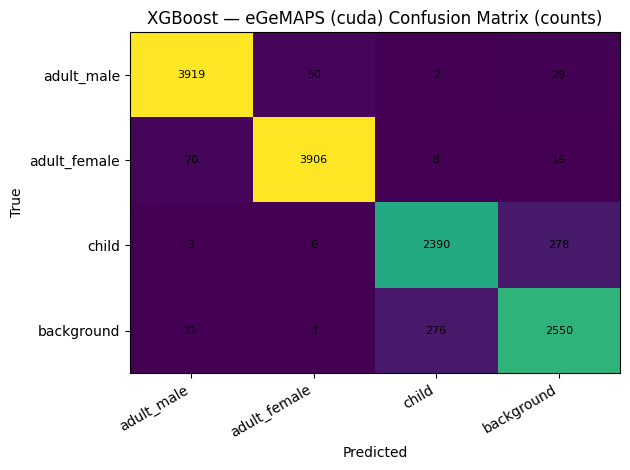

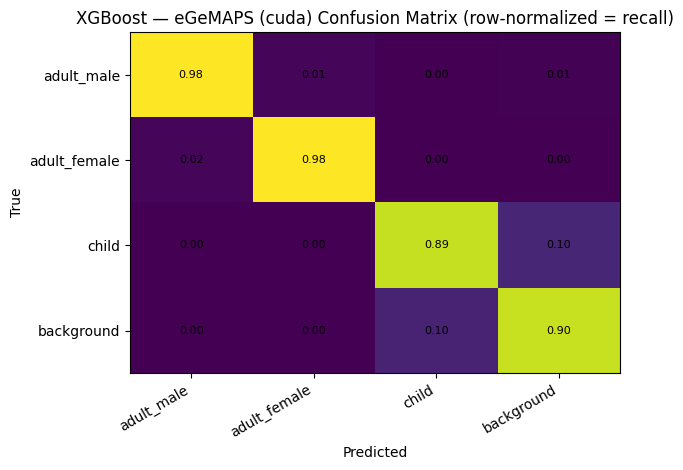

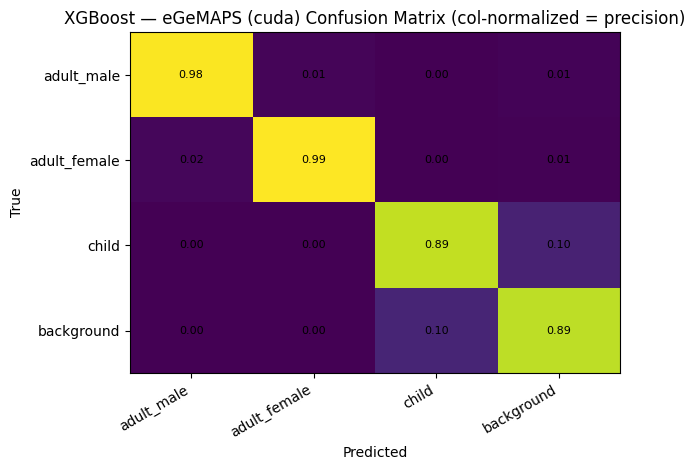

In [24]:
model_e, metrics_e = train_xgb_gpu_fallback(Xtr_e, ytr, Xva_e, yva, "XGBoost — eGeMAPS")


XGBoost — wav2vec2 (cuda)
Train time (sec): 147.33
Accuracy: 0.92195
UAR (macro recall): 0.915041
Macro F1: 0.914918


,label_id,label,support,precision,recall,f1
0,0,adult_male,4000,0.953050,0.949000,0.951021
1,1,adult_female,4000,0.958312,0.954000,0.956151
3,3,background,2840,0.860088,0.896127,0.877738
2,2,child,2677,0.888932,0.861038,0.874763


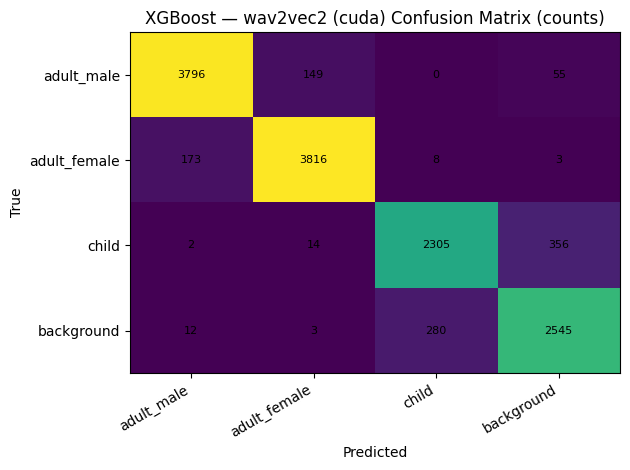

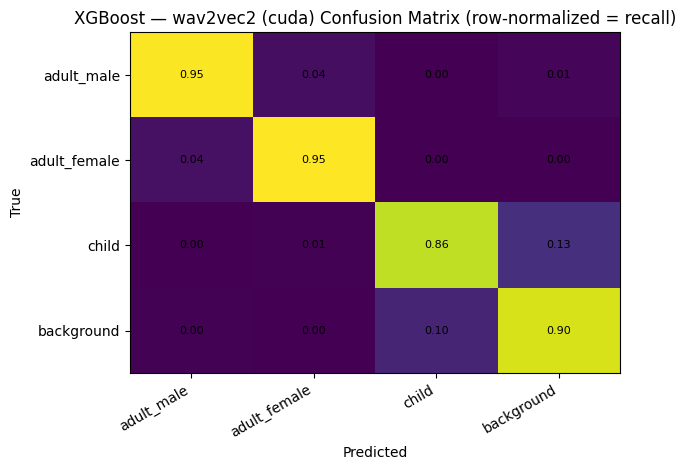

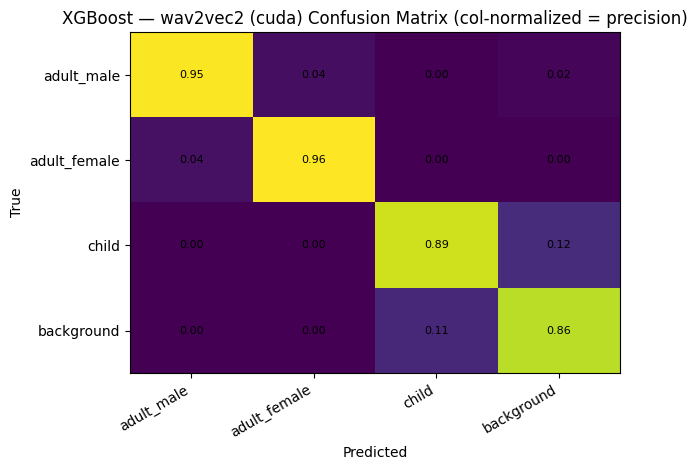

In [25]:
model_w, metrics_w = train_xgb_gpu_fallback(Xtr_w, ytr, Xva_w, yva, "XGBoost — wav2vec2")
